# **Ejercicio 2 (maximización con restricciones lineales)**

**Objetivo:** Maximizar la función Z = 3x₁ + 5x₂ sujeta a un conjunto de restricciones lineales, utilizando algoritmos genéticos con la librería DEAP.

## **Importar librerías necesarias**

Se importan las librerías necesarias para el ejercicio.

* **DEAP:** El framework de computación evolutiva utilizado para construir el algoritmo genético.
* **NumPy:** Para operaciones numéricas, especialmente para el cálculo de estadísticas.
* **random y math:** Librerías estándar de Python para generación de números aleatorios y operaciones matemáticas.

En caso de que DEAP no esté instalada, se puede instalar utilizando pip descomentando la línea de código en la siguiente celda.

In [1]:
# https://deap.readthedocs.io/en/master/
# Instalar el paquete DEAP
# !pip install deap

In [2]:
# Importar paquetes
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from deap import creator, tools, base, algorithms

## **Planteamiento del Problema**

Se busca maximizar la siguiente función objetivo:

$$ \text{Maximizar } Z = 3x_1 + 5x_2 $$

Sujeto a las siguientes restricciones:

$$ x_1 \leq 4000 $$
$$ 2x_2 \leq 12000 \quad (\text{o } x_2 \leq 6000) $$
$$ 3x_1 + 2x_2 \leq 18000 $$
$$ x_1 \geq 0, \quad x_2 \geq 0 $$

## **Funciones de Evaluación y Factibilidad**

Para manejar las restricciones, el algoritmo genético necesita tres funciones clave:

1.  **Función Objetivo:** Calcula el valor de la función Z que se desea maximizar.
2.  **Función de Factibilidad:** Evalúa si una solución (individuo) viola alguna de las restricciones establecidas. Devuelve `True` si es válida y `False` si no lo es.
3.  **Función de Penalización:** Cuando una solución no es factible, esta función calcula una "distancia" o penalización. Esto ayuda al algoritmo a favorecer soluciones que, aunque no sean óptimas, al menos cumplan con las restricciones. DEAP utiliza esta penalización para ajustar el valor de fitness de los individuos no válidos.

In [3]:
# Función Objetivo (F.O.)
# Define la función que se desea optimizar (maximizar en este caso).
# El individuo contiene los valores de las variables de decisión [x1, x2].
def objective_function(individual):
  z = 3*individual[0] + 5*individual[1]
  return z,

# Función de factibilidad
# Verifica si un individuo (solución) cumple con todas las restricciones del problema.
def feasible(individual):
  if (individual[0]) <= 0:
    return False
  if (individual[1]) <= 0:
    return False
  if individual[0] > 4000:
    return False
  if 2*individual[1] > 12000:
    return False
  if (3*individual[0] + 2*individual[1]) > 18000:
    return False
  else:
    return True

# Función de penalización
# Calcula la "distancia" de un individuo a la región factible.
# Esta distancia se usa para penalizar a las soluciones que no cumplen las restricciones.
def distance(individual):
  constraint1 = abs(individual[0] - 4000)
  constraint2 = abs(individual[1]*2 - 12000)
  constraint3 = abs(individual[0]*3 + individual[1]*2 - 18000)

  return (constraint1 + constraint2 + constraint3)

In [4]:
# Prueba de la función objetivo con valores de ejemplo
objective_function([100, 250])

(1550,)

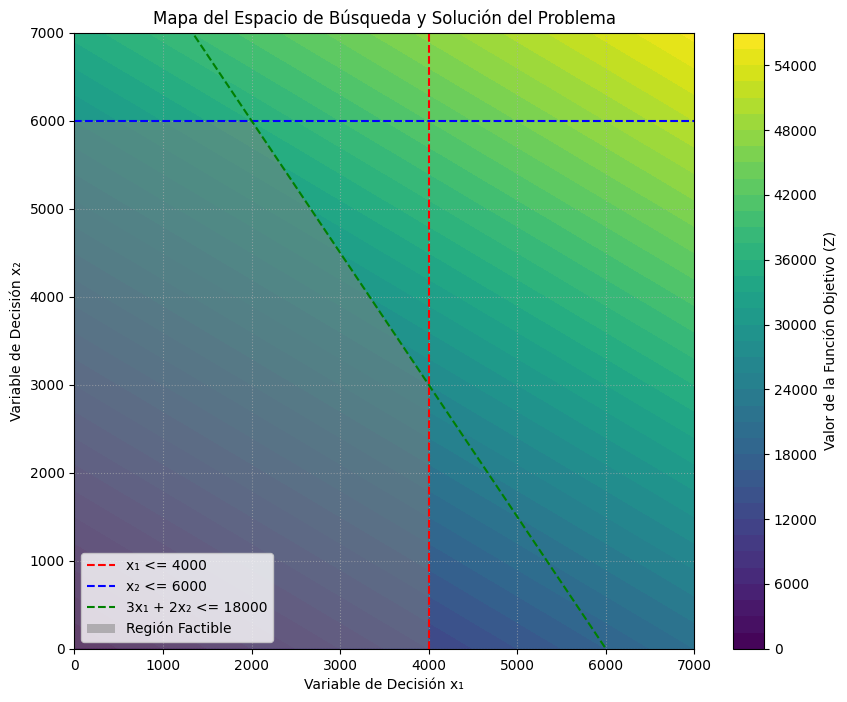

In [5]:
# Visualización del Espacio de Búsqueda y la Región Factible

# Creación del Mapa del Espacio de Búsqueda

# Definir la malla (grid) para el espacio de búsqueda.
# Los límites se eligen para abarcar cómodamente la región factible.
x1_range = np.linspace(0, 7000, 400)
x2_range = np.linspace(0, 7000, 400)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Calcular el valor de la función objetivo (Z) para cada punto de la malla.
Z = 3 * X1 + 5 * X2 # Z = 3x₁ + 5x₂

# Generación del Gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de contorno de la función objetivo.
# 'contourf' crea un mapa de calor. Los valores más altos de Z serán más claros.
contour = plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='Valor de la Función Objetivo (Z)')

# Dibujar las líneas que representan las fronteras de las restricciones.
# Restricción 1: x₁ <= 4000
plt.axvline(x=4000, color='r', linestyle='--', label='x₁ <= 4000')

# Restricción 2: 2x₂ <= 12000  =>  x₂ <= 6000
plt.axhline(y=6000, color='b', linestyle='--', label='x₂ <= 6000')

# Restricción 3: 3x₁ + 2x₂ <= 18000  =>  x₂ <= (18000 - 3x₁) / 2
x1_line = np.array([0, 6000]) # Rango de x1 para la línea
x2_line = (18000 - 3 * x1_line) / 2
plt.plot(x1_line, x2_line, 'g', linestyle='--', label='3x₁ + 2x₂ <= 18000')

# Identificar y sombrear la región factible.
# La región factible es el polígono formado por los vértices que cumplen todas las restricciones.
# Vértices del polígono de la región factible:
# (0,0), (4000,0), (4000,3000), (2000,6000), (0,6000)
x_fill = [0, 4000, 4000, 2000, 0]
y_fill = [0, 0, 3000, 6000, 6000]
plt.fill(x_fill, y_fill, 'grey', alpha=0.5, label='Región Factible')

# Configuración Final del Gráfico
plt.title('Mapa del Espacio de Búsqueda y Solución del Problema')
plt.xlabel('Variable de Decisión x₁')
plt.ylabel('Variable de Decisión x₂')
plt.xlim(0, 7000)
plt.ylim(0, 7000)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## **Configuración del Algoritmo Genético con DEAP**

### **1. Creación de Tipos**
Se definen las estructuras básicas para el fitness y los individuos.

* **FitnessMax:** Se crea un objeto `Fitness` para maximización. El `weights=(1.0,)` indica que se busca maximizar el primer (y único) valor devuelto por la función objetivo.
* **Individual:** Se define que un individuo será una lista de Python, y se le asocia el `FitnessMax` creado.

In [6]:
# Creación de los tipos de Fitness e Individuo
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

### **2. Inicialización de la `Toolbox`**
La `Toolbox` es un contenedor que almacena las funciones que el algoritmo genético utilizará para crear la población y aplicar los operadores genéticos (cruce, mutación, selección).

In [7]:
# Crear la caja de herramientas (Toolbox)
toolbox = base.Toolbox()

# Generador de atributos enteros: Se define cómo se crearán los genes.
# "attr_int" generará un número entero aleatorio entre 0 y 10000.
toolbox.register("attr_int", random.randint, 0, 10000)

# Inicializador de individuo y población
# Un individuo es una lista que contiene 2 variables de decisión (genes).
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 2)
# Una población es una lista de individuos.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### **3. Mutación Personalizada**
Aunque DEAP ofrece operadores de mutación estándar, a veces es útil crear uno personalizado para ajustarse mejor al problema. Esta función de mutación aplica una variación gaussiana a un gen seleccionado aleatoriamente dentro de un individuo.

In [8]:
# Operación de mutación personalizada
def mutation_gaussian_int(individual, indp = 0.5):
  size = int(len(individual))
  gene_idx = random.randint(0, size-1)
  mu = individual[gene_idx]
  if random.random() < indp:
    rnd = random.gauss(0, 50)
    individual[gene_idx] += int(rnd)
  return individual,

### **4. Registro de Operadores Genéticos**
Se registran en la `Toolbox` las funciones para los operadores genéticos principales.

* **evaluate:** Es la función objetivo. Se le aplica un "decorador" `DeltaPenalty` que integra la comprobación de factibilidad (`feasible`) y la penalización (`distance`) para los individuos que no cumplen las restricciones.
* **mate:** Operador de cruce. `cxOnePoint` realiza un cruce de un solo punto.
* **mutate:** Operador de mutación. Se usa la función personalizada `mutation_gaussian_int`.
* **select:** Operador de selección. `selTournament` con `tournsize=3` significa que se seleccionan 3 individuos al azar y el mejor de ellos pasa a la siguiente generación.
* **History:** Se usa para registrar el historial de los individuos a lo largo de las generaciones, lo cual es útil para análisis posteriores.

In [9]:
# Registro de Operadores Genéticos en la Toolbox
import sys

# Evaluate: registra la función objetivo y la decora con la penalización.
toolbox.register('evaluate', objective_function)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0, distance))

# Mate: operador de cruce de un punto.
toolbox.register('mate', tools.cxOnePoint)

# Mutate: operador de mutación personalizado.
toolbox.register('mutate', mutation_gaussian_int, indp = 0.7)

# Select: operador de selección por torneo.
toolbox.register('select', tools.selTournament, tournsize=3)

# Para registrar el historial de individuos
history = tools.History()

# Decorar los operadores de variación para guardar el historial
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

### **5. Configuración Final y Estadísticas**
Antes de ejecutar el algoritmo, se crea la población inicial, se configura el "Salón de la Fama" (`HallOfFame`) para guardar la mejor solución encontrada y se definen las estadísticas que se quieren monitorear en cada generación (promedio, desviación estándar, mínimo y máximo del fitness).

In [10]:
# Creación de la población inicial, historial y estadísticas
pop = toolbox.population(n=100)
history.update(pop)

# hof (HallOfFame) almacena el mejor individuo de todo el proceso
hof = tools.HallOfFame(1)
# Stats registra estadísticas sobre la población en cada generación
stats = tools.Statistics(lambda ind:ind.fitness.values)
stats.register('avg', np.mean)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('max', np.max)

## **Optimización**

Se ejecuta el algoritmo genético (`eaSimple`) con los parámetros definidos:

* **`pop`**: La población inicial.
* **`toolbox`**: El contenedor con todos los operadores.
* **`cxpb`**: Probabilidad de cruce (0.5 o 50%).
* **`mutpb`**: Probabilidad de mutación (0.7 o 70%).
* **`ngen`**: Número de generaciones a ejecutar (200).
* **`stats`**: El objeto de estadísticas para registrar.
* **`halloffame`**: El objeto para guardar al mejor individuo.
* **`verbose=True`**: Muestra el progreso en cada generación.

In [11]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.7, ngen=200,
                                stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std    	min   	max  
0  	100   	-7426.18	18724.7	-42780	34894
1  	90    	4823.43 	17321.3	-24364	34894
2  	86    	18379   	13228.8	-14324	34894
3  	87    	24587.4 	9392.85	-3982 	34412
4  	78    	27568.3 	9028.04	-3982 	34664
5  	90    	27523.4 	11440.1	-4072 	34838
6  	82    	31039.1 	8671.28	-3394 	34779
7  	82    	32350   	8034.03	-2680 	34985
8  	80    	30837.1 	11124.9	-2594 	35349
9  	87    	30279.1 	12074.2	-2534 	35349
10 	85    	28581.1 	14033  	-2632 	35351
11 	77    	29409.2 	13352  	-2464 	35559
12 	84    	28759.8 	14070.2	-2432 	35657
13 	84    	27698.5 	15004.8	-2524 	35657
14 	81    	30753.6 	12200.9	-2400 	35627
15 	89    	26327.1 	16066.8	-2380 	35748
16 	79    	25634.2 	16519.5	-2406 	35748
17 	87    	25278.2 	16715.9	-2350 	35748
18 	89    	29815.5 	13444.4	-2344 	35786
19 	84    	29082.4 	14138.9	-2318 	35775
20 	90    	28371.9 	14787.8	-2290 	35817
21 	84    	28037.8 	15100  	-2392 	35817
22 	84    	26923.8 	15891.9	-2352 	35817
23 	89    	27716

## **Resultados**

Una vez finalizada la ejecución, se muestran los resultados obtenidos.

In [12]:
# Mejor solución encontrada
print('Mejor individuo:', hof[0])

Mejor individuo: [2000, 6000]


In [13]:
# Valor de la Función Objetivo para el mejor individuo:
print('Mejor F.O.:', objective_function(hof[0]))

Mejor F.O.: (36000,)


In [14]:
# Verificar si el mejor individuo cumple con las restricciones
print('Cumple restricciones:', feasible(hof[0]))

Cumple restricciones: True
